In [1]:
import sys

sys.path.append("../../src/stong_core_cython")
sys.path.append("../../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unrestricted_hartree_fock
import basis_data
import importlib
from scipy.ndimage import gaussian_filter1d
from matplotlib.backends.backend_pdf import PdfPages
from scipy.constants import physical_constants
from scipy.optimize import minimize

importlib.reload(unrestricted_hartree_fock)
importlib.reload(basis_data)

from atom import *
from unrestricted_hartree_fock import *
from basis_data import *

hartree_to_ev_factor = physical_constants["Hartree energy in eV"][0]

In [3]:
df = pd.read_csv("../make_base/sto_ng/sto_3g.csv")

In [4]:
df_zetas = pd.read_csv("./zetas_4s.csv")

In [5]:
atom_symbol = "H"
zetas = df_zetas[atom_symbol]
atoms = [Atom(atom_symbol, np.array([0.0, 0.0, 0.0]))]
molecule = Molecule(atoms)
basis_data = {atom_symbol: create_basis_data(df, zetas, 4, 1)}
print(basis_data)

{'H': {'1s': {'exps': array([0.10998665, 0.40715402, 2.24601408]), 'coefs': array([0.44557586, 0.5353617 , 0.15348232]), 'lmn': array([0, 0, 0]), 'zeta': 2.768477113900877}, '2s': {'exps': array([0.07477161, 0.22917082, 0.97836706]), 'coefs': array([ 0.69476149,  0.40560036, -0.10030222]), 'lmn': array([0, 0, 0]), 'zeta': 3.858223031619042}, '2px': {'exps': array([0.07477161, 0.22917082, 0.97836706]), 'coefs': array([0.38812384, 0.6086091 , 0.15864708]), 'lmn': array([1, 0, 0]), 'zeta': 3.858223031619042}, '2py': {'exps': array([0.07477161, 0.22917082, 0.97836706]), 'coefs': array([0.38812384, 0.6086091 , 0.15864708]), 'lmn': array([0, 1, 0]), 'zeta': 3.858223031619042}, '2pz': {'exps': array([0.07477161, 0.22917082, 0.97836706]), 'coefs': array([0.38812384, 0.6086091 , 0.15864708]), 'lmn': array([0, 0, 1]), 'zeta': 3.858223031619042}, '3s': {'exps': array([0.05366248, 0.13907619, 0.45594687]), 'coefs': array([ 0.916705  ,  0.21749709, -0.22773934]), 'lmn': array([0, 0, 0]), 'zeta': 2.

In [6]:
hartreefock = UnrestrictedHartreeFock(molecule, basis_data, max_iter=10000, tol=1e-10)

In [7]:
hartreefock.scf()

Start SCF for Molecule(atoms=[Atom(symbol=H, atomic_number=1, position=[0. 0. 0.])])


In [8]:
def solve(zetas, atom_symbol):
    atoms = [Atom(atom_symbol, np.array([0.0, 0.0, 0.0]))]
    molecule = Molecule(atoms)
    basis_data = {atom_symbol: create_basis_data(df, zetas, 4, 1)}
    hartreefock = UnrestrictedHartreeFock(
        molecule, basis_data, max_iter=10000, tol=1e-10
    )
    hartreefock.scf()
    hartreefock.calculate_total_energy()
    results = hartreefock.get_results()
    return results, hartreefock


def get_energy_lebels(results, df_zetas, atom_symbol, n_occ):
    energy_lebels = np.hstack((results["val_up"], results["val_dn"]))
    energy_lebels = np.sort(energy_lebels)
    return energy_lebels

Start SCF for Molecule(atoms=[Atom(symbol=K, atomic_number=19, position=[0. 0. 0.])])
         energy       dos
0   -131.825171  0.372975
1   -131.692988  0.172233
2   -131.560804  0.033999
3   -131.428621  0.002657
4   -131.296437  0.000078
..          ...       ...
995   -0.302597  0.072163
996   -0.170414  0.139762
997   -0.038230  0.242849
998    0.093953  0.649779
999    0.226137  1.206370

[1000 rows x 2 columns]


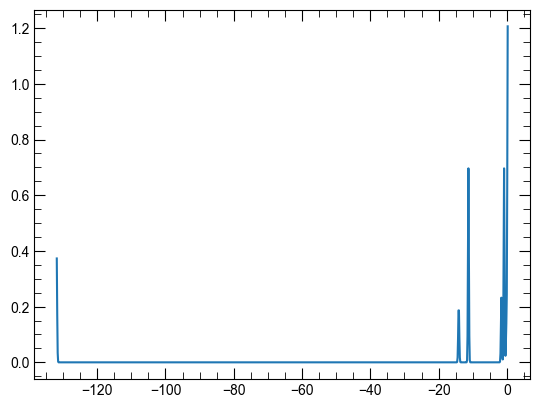

In [9]:
results, hartree_fock = solve(df_zetas["K"], "K")
dos = hartree_fock.calculate_dos(sigma=1, bins=1000)
fig, ax = plt.subplots()
print(dos)
ax.plot(dos["energy"], dos["dos"])
# ax.set_xlim(-1, 10)

In [10]:
pdos_up, pdos_dn = hartree_fock.calculate_pdos_weight()
pdos_up

,energy,1s,2s,2px,2py,2pz,3s,3px,3py,3pz,4s,4px,4py,4pz
0,-131.891263,9.844799e-01,4.635201e-04,4.243513e-22,4.243513e-22,4.243513e-22,1.134059e-05,1.836120e-23,1.836120e-23,1.836120e-23,9.922506e-07,8.739854e-25,8.739854e-25,8.739854e-25
1,-14.116242,1.551026e-01,1.101012e+00,8.044889e-18,8.044890e-18,8.044890e-18,3.844089e-03,1.557517e-19,1.557517e-19,1.557517e-19,2.266806e-04,6.288104e-21,6.288105e-21,6.288105e-21
2,-11.212450,4.161121e-18,3.082062e-17,3.140169e-01,3.293799e-01,3.288825e-01,2.276067e-20,6.808248e-04,7.141335e-04,7.130550e-04,3.593803e-22,3.442896e-05,3.611336e-05,3.605882e-05
3,-11.212450,5.072400e-22,3.757028e-21,6.577484e-01,1.728188e-01,1.417122e-01,2.774093e-24,1.426074e-03,3.746910e-04,3.072483e-04,4.382094e-26,7.211582e-05,1.894793e-05,1.553739e-05
4,-11.212450,2.907963e-36,1.601145e-35,5.140557e-04,4.700806e-01,5.016847e-01,1.802242e-34,1.114532e-06,1.019189e-03,1.087710e-03,3.568993e-32,5.636130e-08,5.153985e-05,5.500493e-05
5,-1.651215,1.408910e-02,1.431186e-01,3.540284e-17,3.540284e-17,3.540284e-17,1.072733e+00,2.896902e-16,2.896902e-16,2.896902e-16,3.892511e-04,2.249072e-17,2.249072e-17,2.249072e-17
6,-0.861929,1.838732e-17,1.913539e-16,3.394900e-02,3.393951e-02,3.392474e-02,1.587739e-15,3.056269e-01,3.055415e-01,3.054085e-01,2.463700e-16,1.108619e-02,1.108309e-02,1.107827e-02
7,-0.861929,2.797520e-25,2.911335e-24,7.822737e-03,2.821089e-02,6.577963e-02,2.415652e-23,7.042442e-02,2.539694e-01,5.921830e-01,3.748419e-24,2.554548e-03,9.212387e-03,2.148062e-02
8,-0.861929,1.178035e-25,1.225963e-24,6.004152e-02,3.966285e-02,2.108885e-03,1.017233e-23,5.405256e-01,3.570660e-01,1.898530e-02,1.578623e-24,1.960681e-02,1.295207e-02,6.886655e-04
9,-0.107191,1.688465e-03,1.828552e-02,3.886077e-16,3.886077e-16,3.886077e-16,1.823721e-01,5.138182e-15,5.138182e-15,5.138182e-15,1.152575e+00,2.100048e-14,2.100048e-14,2.100048e-14


In [11]:
pdos_up, pdos_dn = hartree_fock.calculate_smoothed_pdos(sigma=100, bins=10000)

In [12]:
pdos_up

,energy,1s,2s,2px,2py,2pz,3s,3px,3py,3pz,4s,4px,4py,4pz
0,-132.884553,0.383875,0.000165,1.734497e-22,1.734497e-22,1.734497e-22,0.000004,6.501532e-24,6.501533e-24,6.501533e-24,3.876322e-07,3.377486e-25,3.377486e-25,3.377486e-25
1,-132.871133,0.383858,0.000165,1.734420e-22,1.734420e-22,1.734420e-22,0.000004,6.501243e-24,6.501243e-24,6.501243e-24,3.876149e-07,3.377336e-25,3.377336e-25,3.377336e-25
2,-132.857714,0.383823,0.000165,1.734266e-22,1.734266e-22,1.734266e-22,0.000004,6.500665e-24,6.500665e-24,6.500665e-24,3.875804e-07,3.377035e-25,3.377036e-25,3.377035e-25
3,-132.844294,0.383772,0.000165,1.734034e-22,1.734034e-22,1.734034e-22,0.000004,6.499797e-24,6.499797e-24,6.499797e-24,3.875287e-07,3.376584e-25,3.376585e-25,3.376585e-25
4,-132.830874,0.383704,0.000165,1.733726e-22,1.733726e-22,1.733726e-22,0.000004,6.498639e-24,6.498640e-24,6.498639e-24,3.874597e-07,3.375983e-25,3.375983e-25,3.375983e-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,1.231840,0.001158,0.011069,2.630319e-02,2.630319e-02,2.630319e-02,0.095623,2.397254e-01,2.397254e-01,2.397254e-01,3.442905e-01,4.289497e-01,4.289497e-01,4.289497e-01
9995,1.245260,0.001157,0.011060,2.629535e-02,2.629535e-02,2.629535e-02,0.095552,2.396696e-01,2.396696e-01,2.396696e-01,3.442779e-01,4.290119e-01,4.290119e-01,4.290119e-01
9996,1.258679,0.001156,0.011052,2.628948e-02,2.628948e-02,2.628948e-02,0.095498,2.396278e-01,2.396278e-01,2.396278e-01,3.442684e-01,4.290586e-01,4.290586e-01,4.290586e-01
9997,1.272099,0.001156,0.011048,2.628556e-02,2.628556e-02,2.628556e-02,0.095463,2.395999e-01,2.395999e-01,2.395999e-01,3.442620e-01,4.290897e-01,4.290897e-01,4.290897e-01


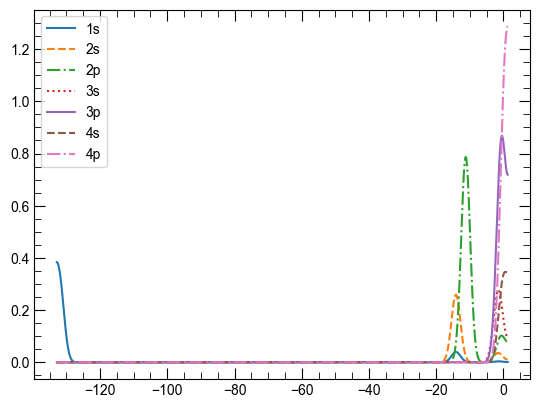

In [13]:
fig, ax = plt.subplots()
linestyles = ["-", "--", "-.", ":"]
ax.plot(pdos_up["energy"], pdos_up["1s"], label="1s", linestyle=linestyles[0])
ax.plot(pdos_up["energy"], pdos_up["2s"], label="2s", linestyle=linestyles[1])
ax.plot(
    pdos_up["energy"],
    pdos_up["2px"] + pdos_up["2py"] + pdos_up["2pz"],
    label="2p",
    linestyle=linestyles[2],
)
ax.plot(pdos_up["energy"], pdos_up["3s"], label="3s", linestyle=linestyles[3])
ax.plot(
    pdos_up["energy"],
    pdos_up["3px"] + pdos_up["3py"] + pdos_up["3pz"],
    label="3p",
    linestyle=linestyles[0],
)
ax.plot(pdos_up["energy"], pdos_up["4s"], label="4s", linestyle=linestyles[1])
ax.plot(
    pdos_up["energy"],
    pdos_up["4px"] + pdos_up["4py"] + pdos_up["4pz"],
    label="4p",
    linestyle=linestyles[2],
)
ax.legend()
fig.savefig("pdos.pdf")